In [ ]:
"""
Script for measuring FPS of UCF-101 and extract frames with 25 frame rates
"""

In [1]:
import av
import glob
import os
import time
import tqdm
import datetime
import argparse

In [2]:
dataset_path = 'data/UCF-101'

In [3]:
video_paths = glob.glob(os.path.join(dataset_path, "*", "*.avi"))

In [64]:
# Check frame rate
count25 = countelse = 0
for i, video_path in enumerate(video_paths):
    sequence_type, sequence_name = video_path.split(".avi")[0].split("/")[-2:]
    sequence_path = os.path.join(f"{dataset_path}-for-i3d", sequence_type, sequence_name)
    
    video = av.open(video_path)
    fps = video.streams.video[0].average_rate
    if (fps != 25):
        countelse += 1
    else:
        count25 += 1
#     if os.path.exists(sequence_path):
#         continue

#     os.makedirs(sequence_path, exist_ok=True)
#     break

In [10]:
import glob
import random
import os
import numpy as np
import torch

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


class Dataset(Dataset):
    def __init__(self, dataset_path, split_path, split_number, input_shape, 
                 sequence_length, training):
        self.training = training
        self.label_index = self._extract_label_mapping(split_path)
        self.sequences = self._extract_sequence_paths(dataset_path, split_path, split_number, training)
        self.sequence_length = sequence_length
        self.label_names = sorted(list(set([self._activity_from_path(seq_path) for seq_path in self.sequences])))
        self.num_classes = len(self.label_names)
        if self.training:
            self.transform = transforms.Compose(
                [
                    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
                    transforms.RandomCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            )
        else:
            self.transform = transforms.Compose(
                [
                    transforms.Resize(224, transforms.InterpolationMode.BICUBIC),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
#                     transforms.Normalize(mean, std),
                ]
            )
            

    def _extract_label_mapping(self, split_path="data/ucfTrainTestlist"):
        """ Extracts a mapping between activity name and softmax index """
        with open(os.path.join(split_path, "classInd.txt")) as file:
            lines = file.read().splitlines()
        label_mapping = {}
        for line in lines:
            label, action = line.split()
            label_mapping[action] = int(label) - 1
        return label_mapping

    def _extract_sequence_paths(
        self, dataset_path, split_path="data/ucfTrainTestlist", split_number=1, training=True
    ):
        """ Extracts paths to sequences given the specified train / test split """
        assert split_number in [1, 2, 3], "Split number has to be one of {1, 2, 3}"
        fn = f"trainlist0{split_number}.txt" if training else f"testlist0{split_number}.txt"
        split_path = os.path.join(split_path, fn)
        with open(split_path) as file:
            lines = file.read().splitlines()
        sequence_paths = []
        for line in lines:
            seq_name = line.split(".avi")[0]
            sequence_paths += [os.path.join(dataset_path, seq_name)]
        return sequence_paths

    def _activity_from_path(self, path):
        """ Extracts activity name from filepath """
        return path.split("/")[-2]

    def _frame_number(self, image_path):
        """ Extracts frame number from filepath """
        return int(image_path.split("/")[-1].split(".jpg")[0])

    def _pad_to_length(self, sequence):
        """ Pads the sequence to required sequence length """
        left_pad = sequence[0]
        if self.sequence_length is not None:
            while len(sequence) < self.sequence_length:
                sequence.insert(0, left_pad)
        return sequence

    def __getitem__(self, index):
        sequence_path = self.sequences[index % len(self)]
        # Sort frame sequence based on frame number
        image_paths = sorted(glob.glob(f"{sequence_path}/*.jpg"), key=lambda path: self._frame_number(path))
        # Pad frames sequences shorter than `self.sequence_length` to length
        image_paths = self._pad_to_length(image_paths)
        if self.training:
            # Randomly choose sample interval and start frame
            #sample_interval = np.random.randint(1, len(image_paths) // self.sequence_length + 1)
            #start_i = np.random.randint(0, len(image_paths) - sample_interval * self.sequence_length + 1)
            start_i = np.random.randint(0, len(image_paths) - self.sequence_length + 1)
            flip = np.random.random() < 0.5
        else:
            # Start at first frame and sample uniformly over sequence
            # start_i = 0
            # sample_interval = 1 if self.sequence_length is None else len(image_paths) // self.sequence_length
            start_i = np.random.randint(0, len(image_paths) - self.sequence_length + 1)
            flip = False
        # Extract frames as tensors
        image_sequence = []
        for i in range(start_i, start_i+self.sequence_length):
            if self.sequence_length is None or len(image_sequence) < self.sequence_length:
                image_tensor = self.transform(Image.open(image_paths[i]))
                if flip:
                    image_tensor = torch.flip(image_tensor, (-1,))
                image_sequence.append(image_tensor)
        image_sequence = torch.stack(image_sequence)
        target = self.label_index[self._activity_from_path(sequence_path)]
        return image_sequence, target

    def __len__(self):
        return len(self.sequences)


In [13]:
from torch.utils.data import DataLoader
test_dataset = Dataset(
    dataset_path="data/UCF-101-frames",
    split_path="data/ucfTrainTestlist",
    split_number=1,
    input_shape=(3,224,224),
    sequence_length=64,
    training=True,
)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [14]:
for images, label in test_dataloader:
    break

In [49]:
l = torch.tensor(test_dataset.label_index['ApplyEyeMakeup'])

In [50]:
label = torch.nn.functional.one_hot(l, num_classes=101).repeat((64,1)).permute(1,0)

In [57]:
label.float()

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


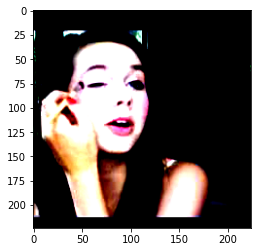

In [44]:
plt.imshow(images[2,56].permute(1,2,0))

In [ ]:
image_tensor = self.transform(Image.open(image_paths[i]))

In [50]:
test = Image.open("/home/sangwooji/git/pytorch-i3d/data/UCF-101-frames/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01/0.jpg")

In [62]:

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(mean, std)

In [65]:
normalize(transforms.ToTensor()(test)).min()

tensor(-2.1179)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


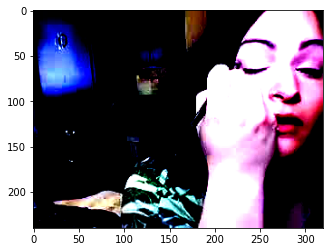

In [63]:
plt.imshow(normalize(transforms.ToTensor()(test)).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


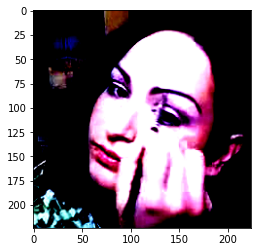

In [29]:
plt.imshow(images[5,19].permute(1,2,0))

In [1]:
import pandas as pd

In [5]:
df = pd.read_csv('Charades_v1_test.csv')

In [8]:
df['actions'][0]

'c077 12.10 18.00;c079 11.80 17.30;c080 13.00 18.00;c076 11.80 17.50;c075 5.40 14.10'

In [1]:
import glob
import random
import os
import numpy as np
import torch

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# Normalization parameters for pre-trained PyTorch models
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

# Normalization parameters for pre-trained I3D models
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

"""
Modify ActionRecognition's code
"""
class UCF101Dataset(Dataset):
    def __init__(self, dataset_path, split_path, split_number, input_shape, sequence_length, training, test_random=False):
        self.training = training
        self.test_random = test_random
        self.label_index = self._extract_label_mapping(split_path)
        self.sequences = self._extract_sequence_paths(dataset_path, split_path, split_number, training)
        self.sequence_length = sequence_length
        self.label_names = sorted(list(set([self._activity_from_path(seq_path) for seq_path in self.sequences])))
        self.num_classes = len(self.label_names)
        if self.training:
            self.transform = transforms.Compose(
                [
                    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
                    transforms.RandomCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            )
        else:
            self.transform = transforms.Compose(
                [
                    transforms.Resize(224, transforms.InterpolationMode.BICUBIC),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            )

    def _extract_label_mapping(self, split_path="data/ucfTrainTestlist"):
        """ Extracts a mapping between activity name and softmax index """
        with open(os.path.join(split_path, "classInd.txt")) as file:
            lines = file.read().splitlines()
        label_mapping = {}
        for line in lines:
            label, action = line.split()
            label_mapping[action] = int(label) - 1
        return label_mapping

    def _extract_sequence_paths(
        self, dataset_path, split_path="data/ucfTrainTestlist", split_number=1, training=True
    ):
        """ Extracts paths to sequences given the specified train / test split """
        assert split_number in [1, 2, 3], "Split number has to be one of {1, 2, 3}"
        fn = f"trainlist0{split_number}.txt" if training else f"testlist0{split_number}.txt"
        split_path = os.path.join(split_path, fn)
        with open(split_path) as file:
            lines = file.read().splitlines()
        sequence_paths = []
        for line in lines:
            seq_name = line.split(".avi")[0]
            sequence_paths += [os.path.join(dataset_path, seq_name)]
        return sequence_paths

    def _activity_from_path(self, path):
        """ Extracts activity name from filepath """
        return path.split("/")[-2]

    def _frame_number(self, image_path):
        """ Extracts frame number from filepath """
        return int(image_path.split("/")[-1].split(".jpg")[0])

    def _pad_to_length(self, sequence):
        """ Pads the sequence to required sequence length """
        left_pad = sequence[0]
        if self.sequence_length is not None:
            while len(sequence) < self.sequence_length:
                sequence.insert(0, left_pad)
        return sequence

    def __getitem__(self, index):
        sequence_path = self.sequences[index % len(self)]
        # Sort frame sequence based on frame number
        image_paths = sorted(glob.glob(f"{sequence_path}/*.jpg"), key=lambda path: self._frame_number(path))
        # Pad frames sequences shorter than `self.sequence_length` to length
        image_paths = self._pad_to_length(image_paths)
        if self.training:
            # Randomly choose sample interval and start frame
            start_i = np.random.randint(0, len(image_paths) - self.sequence_length + 1)
            flip = np.random.random() < 0.5
        else:
            # Start at first frame and sample uniformly over sequence
            start_i = np.random.randint(0, len(image_paths) - self.sequence_length + 1)
            flip = False
        # Extract frames as tensors
        image_sequence = []
        for i in range(start_i, start_i+self.sequence_length):
            if self.sequence_length is None or len(image_sequence) < self.sequence_length:
                image_tensor = self.transform(Image.open(image_paths[i]))
                if flip:
                    image_tensor = torch.flip(image_tensor, (-1,))
                image_sequence.append(image_tensor)
        # convert (T, C, W, H) --> (C, T, W, H)
        image_sequence = torch.stack(image_sequence).permute(1,0,2,3)
        t = self.label_index[self._activity_from_path(sequence_path)]
        target = torch.nn.functional.one_hot(torch.tensor(t), num_classes=101).repeat((64,1)).permute(1,0)
        return image_sequence, target.float()

    def __len__(self):
        return len(self.sequences)


In [4]:
from torch.utils.data import DataLoader
test_dataset = UCF101Dataset(
    dataset_path="data/UCF-101-frames",
    split_path="data/ucfTrainTestlist",
    split_number=1,
    input_shape=(3,224,224),
    sequence_length=64,
    training=False,
)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [5]:
for images,labels in test_dataloader:
    break

UnboundLocalError: Caught UnboundLocalError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sangwooji/miniconda3/envs/colorfusion/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/sangwooji/miniconda3/envs/colorfusion/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/sangwooji/miniconda3/envs/colorfusion/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_9981/2321465681.py", line 107, in __getitem__
    for i in range(start_i, start_i+self.sequence_length):
UnboundLocalError: local variable 'start_i' referenced before assignment
